In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import os
from os.path import expanduser
home_dir = expanduser("~")
module_path = home_dir + '/code/modules/'
models_path = home_dir + '/models/'
import sys
sys.path.append(module_path)
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
from scipy import stats
import json
import pandas as pd
%load_ext autoreload
%autoreload 1
%aimport data_processing
from data_processing import *

## Construct mock SMF

In [98]:
original_directory = '/home/magnus/data/galcats_nonzero_sfr_no_density_with_growth_rate_no_lastMajM/'
destination_directory = '/home/magnus/data/mock_data/stellar_mass_functions/'

redshifts = [0, .1, .2, .5, 1, 2, 3, 4, 6, 8]
bin_width = .1
error = .3

for redshift in redshifts:

    file_name = 'galaxies.Z{:02.0f}'.format(redshift*10)

    galfile = pd.read_hdf(original_directory + file_name + '.h5')
    galaxies = galfile.values
    gal_header = galfile.keys().tolist()

    data_keys = {}
    for col_nr, key in enumerate(gal_header):
        data_keys[key] = col_nr

    # Remove the smaller haloes
    galaxies = galaxies[galaxies[:,data_keys['Halo_mass']] > 10.5, :]

  #  print(np.amax(galaxies[:, data_keys['Halo_mass']]))
  #  print(np.amin(galaxies[:, data_keys['Halo_mass']]))

    max_stellar_mass = np.amax(galaxies[:, data_keys['Stellar_mass']])
    min_stellar_mass = np.amin(galaxies[:, data_keys['Stellar_mass']])
    lower_bin_edge = np.floor(min_stellar_mass * 10)/10
    upper_bin_edge = np.ceil(max_stellar_mass* 10)/10
   # print(min_stellar_mass, max_stellar_mass)
   # print(lower_bin_edge, upper_bin_edge)

    bin_edges = np.arange(lower_bin_edge, upper_bin_edge + bin_width, bin_width)
    n_bins = len(bin_edges)-1
    bin_stats = stats.binned_statistic(galaxies[:, data_keys['Stellar_mass']], galaxies[:, data_keys['Stellar_mass']], 
                                       bins=bin_edges)

    bin_counts = [np.sum(bin_stats[2] == i) for i in range(1, n_bins+1)]

    bin_centers = [(bin_edges[i] + bin_edges[i+1])/2 for i in range(len(bin_edges)-1)]
  #  print(bin_centers)

    #plt.hist(galaxies[:, data_keys['Stellar_mass']], bins = bin_edges, density = False, label = 'Stellar_mass')
  #  plt.scatter(bin_centers, bin_counts)

  #  print(bin_counts)
    bin_counts = [float('nan') if count == 0 else count for count in bin_counts]
    bin_counts_arr = np.array(bin_counts, dtype=np.float)
    bin_counts_per_mpc3 = bin_counts_arr / 200**3 / bin_width
    bin_counts_per_mpc3[bin_counts_per_mpc3 > 0] = np.log10(bin_counts_per_mpc3[bin_counts_per_mpc3 > 0])
  #  print(bin_counts_per_mpc3)

    full_data_list = [[stell_mass, phi, error] for (stell_mass, phi) in zip(bin_centers, bin_counts_per_mpc3) 
                      if (not np.isnan(phi)) ]
    full_data_list.insert(0, {'bin_widths': bin_width, 'bin_edges': bin_edges.tolist()})
  #  print(full_data_list)

    with open(destination_directory + file_name + '.json', 'w+') as f:
        json.dump(full_data_list, f)
    f.close()

In [ ]:
### Try loading a data file
file_name = 'galaxies.Z00'
with open(destination_directory + file_name + '.json', 'r') as f:
    test = json.load(f)
f.close()
print(test)

## Construct mock SSFR

In [99]:
original_directory = '/home/magnus/data/galcats_nonzero_sfr_no_density_with_growth_rate_no_lastMajM/'
destination_directory = '/home/magnus/data/mock_data/ssfr/'
redshifts = [0, .1, .2, .5, 1, 2, 3, 4, 6, 8]

for redshift in redshifts:

    file_name = 'galaxies.Z{:02.0f}'.format(redshift*10)
    
    bin_width = .2
    error = .3

    galfile = pd.read_hdf(original_directory + file_name + '.h5')
    galaxies = galfile.values
    gal_header = galfile.keys().tolist()

    data_keys = {}
    for col_nr, key in enumerate(gal_header):
        data_keys[key] = col_nr

    # Remove the smaller haloes
    galaxies = galaxies[galaxies[:,data_keys['Halo_mass']] > 10.5, :]

    # print(np.amax(galaxies[:, data_keys['Halo_mass']]))
    # print(np.amin(galaxies[:, data_keys['Halo_mass']]))

    sfr_log = galaxies[:, data_keys['SFR']]
    sfr = np.power(10, sfr_log)
    # print(np.amax(sfr))
    # print(np.amin(sfr))

    stellar_mass_log = galaxies[:, data_keys['Stellar_mass']]
    stellar_mass = np.power(10, stellar_mass_log)
    # print('{:.3e}'.format(np.amax(stellar_mass)))
    # print('{:.3e}'.format(np.amin(stellar_mass)))

    ssfr = sfr / stellar_mass
    ssfr_log = np.log10(ssfr)

    max_stellar_mass = np.amax(stellar_mass_log)
    min_stellar_mass = np.amin(stellar_mass_log)
    lower_bin_edge = np.floor(min_stellar_mass * 10)/10
    upper_bin_edge = np.ceil(max_stellar_mass* 10)/10
    # print(min_stellar_mass, max_stellar_mass)
    # print(lower_bin_edge, upper_bin_edge)
    if (upper_bin_edge - lower_bin_edge) % bin_width > 1e-5 and (upper_bin_edge - lower_bin_edge) % bin_width < bin_width - 1e-5:
    #     print((upper_bin_edge - lower_bin_edge) % bin_width)
    #     print('hej')
        upper_bin_edge += (upper_bin_edge - lower_bin_edge) % bin_width
    # print(lower_bin_edge, upper_bin_edge)

    bin_edges = np.arange(lower_bin_edge, upper_bin_edge + bin_width, bin_width)
    n_bins = len(bin_edges)-1
    bin_stats_means = stats.binned_statistic(stellar_mass_log, ssfr_log, bins=bin_edges, statistic='mean')
    bin_stats_stds = stats.binned_statistic(stellar_mass_log, ssfr_log, bins=bin_edges, statistic=np.std)
    bin_means = bin_stats_means[0]
    bin_stds = bin_stats_stds[0]
    # print(bin_means)
    # print(bin_stds)

    bin_centers = [(bin_edges[i] + bin_edges[i+1])/2 for i in range(len(bin_edges)-1)]
    # print(bin_edges)
    # print(bin_centers)

    # plt.errorbar(bin_centers, bin_means, yerr=bin_stds, fmt = 'bo')

    full_data_list = [[stell_mass, mean_ssfr_log, error] for (stell_mass, mean_ssfr_log) in zip(bin_centers, bin_means)]
    full_data_list.insert(0, {'bin_widths': bin_width, 'bin_edges': bin_edges.tolist()})
    # print(full_data_list)

    with open(destination_directory + file_name + '.json', 'w+') as f:
        json.dump(full_data_list, f)
    f.close()

## Construct mock fraction of quenched galaxies

In [100]:
original_directory = '/home/magnus/data/galcats_nonzero_sfr_no_density_with_growth_rate_no_lastMajM/'
destination_directory = '/home/magnus/data/mock_data/fq/'
redshifts = [0, .1, .2, .5, 1, 2, 3, 4, 6, 8]

np.seterr(invalid='raise')

for i_red, redshift in enumerate(redshifts):
#     redshift = redshifts[2]
    scale_factor = 1 / (1 + redshift)

    h_0 = 67.81 / (3.09e19) # 1/s
    h_0 = h_0 * 60 * 24 * 365 # 1/yr
    h_r = h_0 * np.sqrt(1e-3*scale_factor**(-4) + 0.308*scale_factor**(-3) + 0*scale_factor**(-2) + 0.692)
    ssfr_cutoff = 0.3*h_r
    log_ssfr_cutoff = np.log10(ssfr_cutoff)
#     print('log ssfr cutoff: ', log_ssfr_cutoff)

    file_name = 'galaxies.Z{:02.0f}'.format(redshift*10)

    bin_width = .25
    error = .3

    galfile = pd.read_hdf(original_directory + file_name + '.h5')
    galaxies = galfile.values
    gal_header = galfile.keys().tolist()

    data_keys = {}
    for col_nr, key in enumerate(gal_header):
        data_keys[key] = col_nr

    # Remove the smaller haloes
    galaxies = galaxies[galaxies[:,data_keys['Halo_mass']] > 10.5, :]

    # print(np.amax(galaxies[:, data_keys['Halo_mass']]))
    # print(np.amin(galaxies[:, data_keys['Halo_mass']]))

    sfr_log = galaxies[:, data_keys['SFR']]
    sfr = np.power(10, sfr_log)
    # print(np.amax(sfr))
    # print(np.amin(sfr))

    stellar_mass_log = galaxies[:, data_keys['Stellar_mass']]
    stellar_mass = np.power(10, stellar_mass_log)
    # print('{:.3e}'.format(np.amax(stellar_mass)))
    # print('{:.3e}'.format(np.amin(stellar_mass)))

    ssfr = sfr / stellar_mass

    # print(np.min(ssfr), np.max(ssfr))
    # print(h_r)

    ssfr_log = np.log10(ssfr)

    max_stellar_mass = np.amax(stellar_mass_log)
    min_stellar_mass = np.amin(stellar_mass_log)
    lower_bin_edge = np.floor(min_stellar_mass * 1/bin_width)*bin_width
    upper_bin_edge = np.ceil(max_stellar_mass * 1/bin_width)*bin_width
#     print(min_stellar_mass, max_stellar_mass)
#     print(lower_bin_edge, upper_bin_edge)
    if (upper_bin_edge - lower_bin_edge) % bin_width > 1e-5 and (upper_bin_edge - lower_bin_edge) % bin_width < bin_width - 1e-5:
    #     print((upper_bin_edge - lower_bin_edge) % bin_width)
        upper_bin_edge += (upper_bin_edge - lower_bin_edge) % bin_width
#     print(lower_bin_edge, upper_bin_edge)

    bin_edges = np.arange(lower_bin_edge, upper_bin_edge + bin_width, bin_width)
    n_bins = len(bin_edges)-1
    bin_means, bin_edges, bin_numbers = stats.binned_statistic(stellar_mass_log, ssfr_log, bins=bin_edges, statistic='mean')

    bin_fqs = []
    for bin_num in range(1, n_bins+1):
        try:
            fq = np.sum(ssfr_log[bin_numbers == bin_num] < log_ssfr_cutoff) / len(ssfr_log[bin_numbers == bin_num])
        except:
            if len(ssfr_log[bin_numbers == bin_num]) == 0:
                print('bin number {:d} contains 0 points'.format(bin_num))
                fq = 0
            else:
                print('some other error')
        bin_fqs.append(fq)

    bin_centers = [(bin_edges[i] + bin_edges[i+1])/2 for i in range(len(bin_edges)-1)]
#     fig = plt.figure(i_red)
#     ax = plt.gca()
#     plt.plot(bin_centers, bin_fqs)
#     ax.set_ylim(bottom=0)
#     ax.set_ylim(top=1)
#     plt.title('Fraction of quenched galaxies at redshift {:.1f}'.format(redshift))
#     fig.savefig('fq_Z{:02.0f}.png'.format(redshift*10), bbox_inches = 'tight')
# plt.show()

# print(bin_edges)
# print(bin_centers)

# plt.errorbar(bin_centers, bin_means, yerr=bin_stds, fmt = 'bo')

    full_data_list = [[stell_mass, fq, error] for (stell_mass, fq) in zip(bin_centers, bin_fqs)]
    full_data_list.insert(0, {'bin_widths': bin_width, 'bin_edges': bin_edges.tolist()})

    with open(destination_directory + file_name + '.json', 'w+') as f:
        json.dump(full_data_list, f)
    f.close()

### Mock stellar mass halo mass relationship

10.502208 15.155734
10.4 15.200000000000001


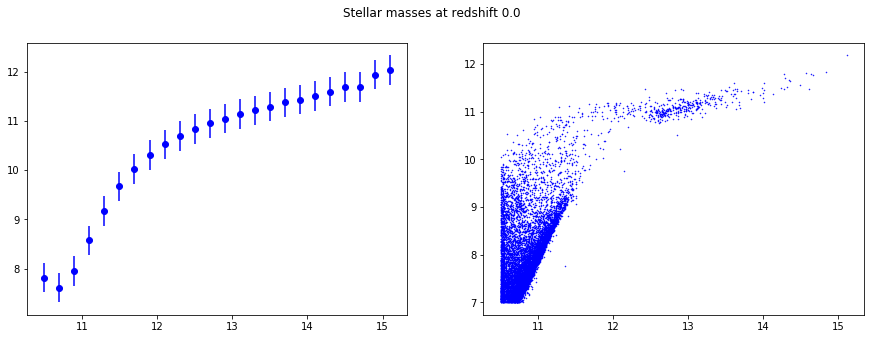

10.500187 15.179262
10.4 15.200000000000001


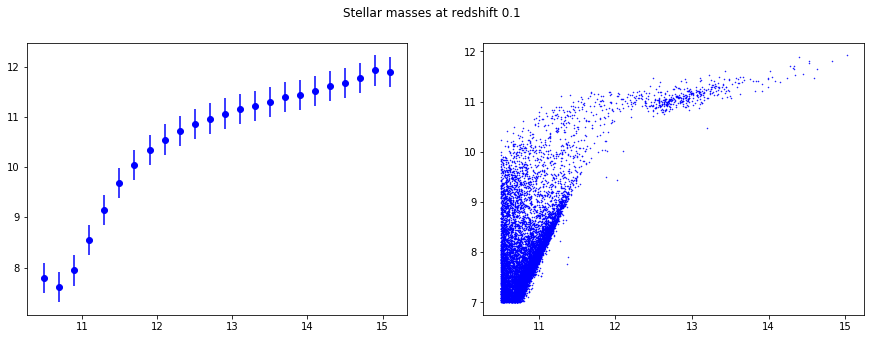

10.502007 15.163807
10.4 15.200000000000001


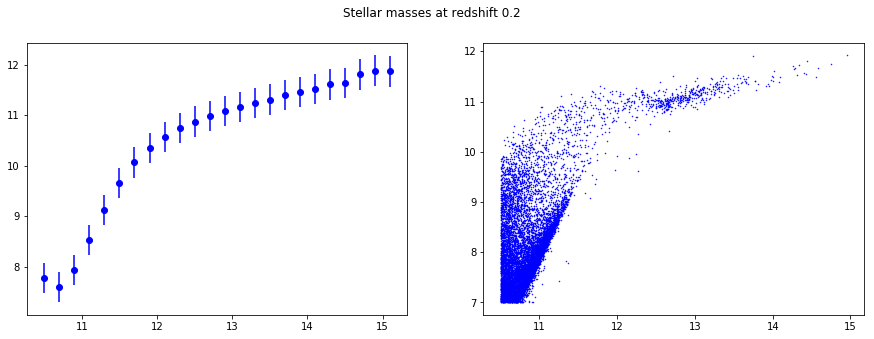

10.500187 14.791384
10.4 14.8


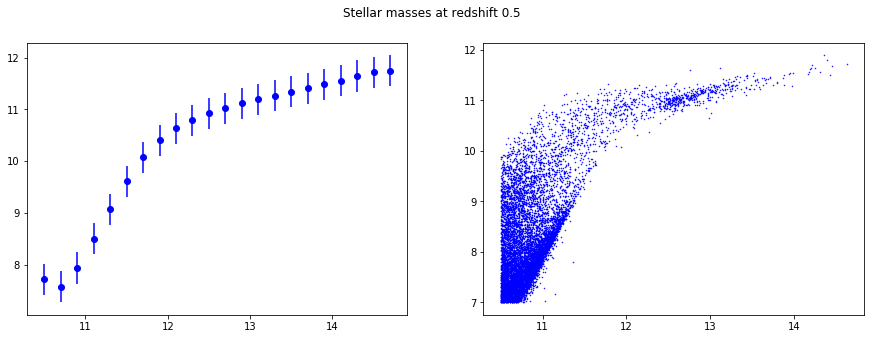

10.502007 14.597583
10.4 14.600000000000001


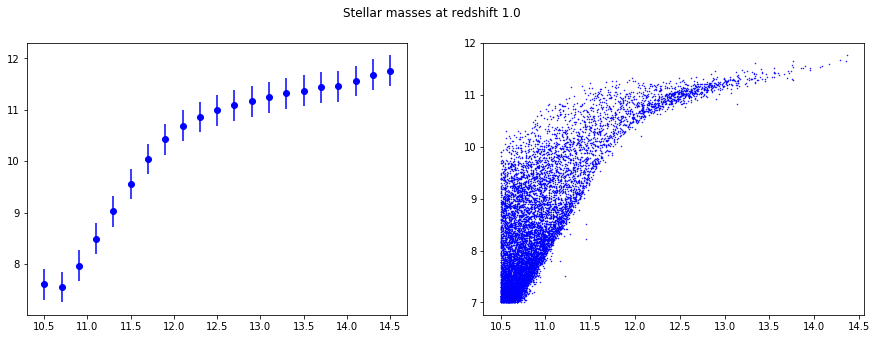

10.500187 14.071238
10.4 14.200000000000001


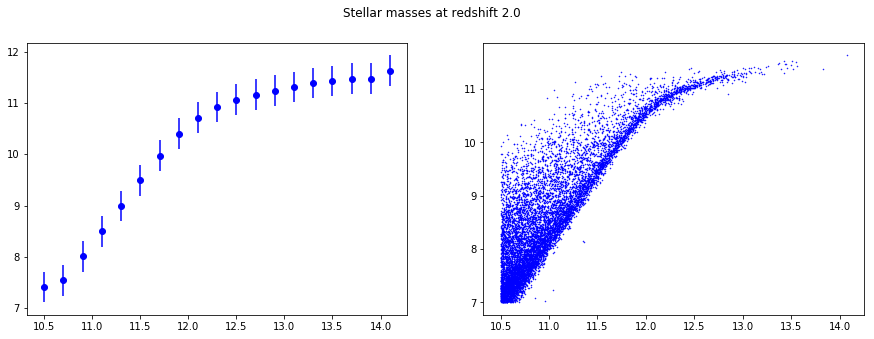

10.500187 13.582094
10.4 13.600000000000001


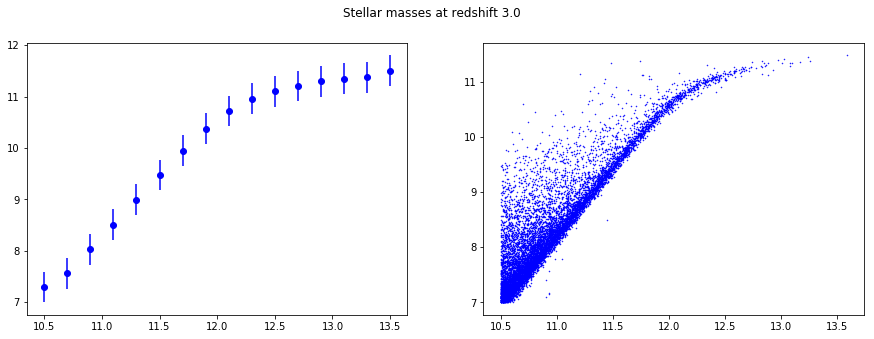

10.500187 13.192215
10.4 13.200000000000001


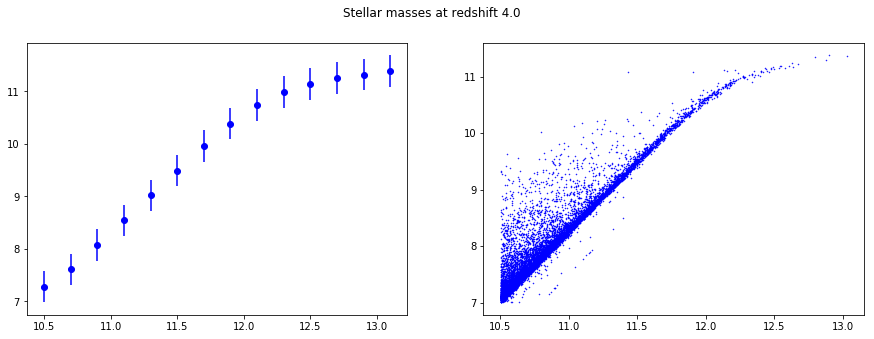

10.500187 12.421573
10.4 12.600000000000001


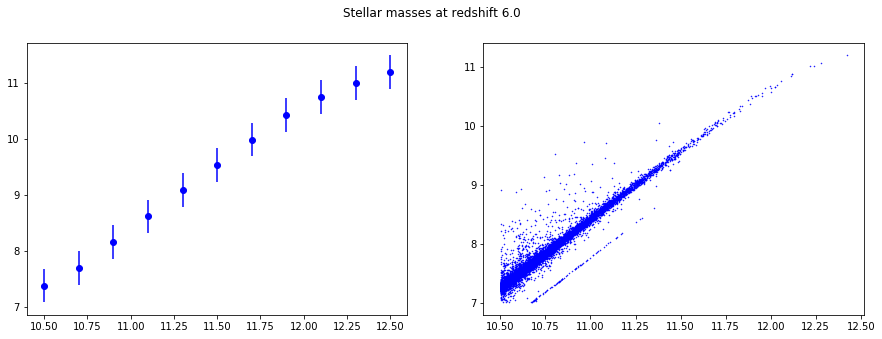

10.500187 11.842904
10.4 12.0


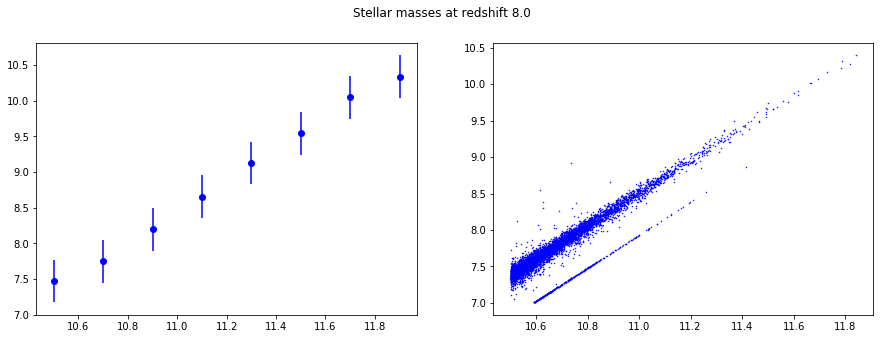

In [24]:
original_directory = '/home/magnus/data/galcats_nonzero_sfr_no_density_with_growth_rate_no_lastMajM/'
destination_directory = '/home/magnus/data/mock_data/stellar_halo_mass_relations/'
redshifts = [0, .1, .2, .5, 1, 2, 3, 4, 6, 8]

np.seterr(invalid='raise')

for i_red, redshift in enumerate(redshifts):

    file_name = 'galaxies.Z{:02.0f}'.format(redshift*10)

    bin_width = .2
    error = .3

    galfile = pd.read_hdf(original_directory + file_name + '.h5')
    galaxies = galfile.values
    gal_header = galfile.keys().tolist()

    data_keys = {}
    for col_nr, key in enumerate(gal_header):
        data_keys[key] = col_nr

    # Remove the smaller haloes
    galaxies = galaxies[galaxies[:,data_keys['Halo_mass']] > 10.5, :]

    halo_mass = galaxies[:, data_keys['Halo_mass']]
    stellar_mass = galaxies[:, data_keys['Stellar_mass']]

    min_halo_mass = np.amin(halo_mass)
    max_halo_mass = np.amax(halo_mass)
    
    lower_bin_edge = np.floor(min_halo_mass * 1/bin_width)*bin_width
    upper_bin_edge = np.ceil(max_halo_mass * 1/bin_width)*bin_width
    print(min_halo_mass, max_halo_mass)
    print(lower_bin_edge, upper_bin_edge)

    if (upper_bin_edge - lower_bin_edge) % bin_width > 1e-5 and (upper_bin_edge - lower_bin_edge) % bin_width < bin_width - 1e-5:
        print((upper_bin_edge - lower_bin_edge) % bin_width)
        upper_bin_edge += (upper_bin_edge - lower_bin_edge) % bin_width
#     print(lower_bin_edge, upper_bin_edge)

    bin_edges = np.arange(lower_bin_edge, upper_bin_edge + bin_width, bin_width)
    n_bins = len(bin_edges)-1
    bin_means, bin_edges, bin_numbers = stats.binned_statistic(halo_mass, stellar_mass, bins=bin_edges, statistic='mean')

    bin_centers = [(bin_edges[i] + bin_edges[i+1])/2 for i in range(len(bin_edges)-1)]
    fig = plt.figure(i_red, figsize=(15,5))
    ax = plt.subplot(121)
    ax.errorbar(bin_centers, bin_means, yerr=error*np.ones(len(bin_centers)), fmt = 'bo')
    ax = plt.subplot(122)
    ax.plot(halo_mass[:10000], stellar_mass[:10000], 'b.', markersize=1)
    plt.suptitle('Stellar masses at redshift {:.1f}'.format(redshift))
    plt.show()

    

    full_data_list = [[halo_mass, stellar_mass, error] for (halo_mass, stellar_mass) in zip(bin_centers, bin_means)]
    full_data_list.insert(0, {'bin_widths': bin_width, 'bin_edges': bin_edges.tolist()})

    with open(destination_directory + file_name + '.json', 'w+') as f:
        json.dump(full_data_list, f)
    f.close()

### Real data

In [ ]:
filename = '/home/magnus/data/observational_data/all_data.h5'
file = h5py.File(filename, 'r')
#file?
# List all groups
print("Keys: ", list(file.keys()))

In [ ]:
# Get the universe
universe_0 = file['Universe_0']
#universe_0?
# List all objects in the universe
print("Keys: ", list(universe_0.keys()))

In [ ]:
# Get the SMF objects from the universe
smf = universe_0['SMF']
#smf?
# List all objects
print("Keys: ", list(smf.keys()))
# Get the dataset 'Data'
data = smf['Data']
print("Keys of Data: ", list(data.keys()))
data_keys = list(data.keys())
model = smf['Model']
sets = smf['Sets']

In [ ]:
print(list(sets))
#sets?

In [ ]:
print(list(model))
#model?

In [ ]:
#print(list(data['000 Li & White 2009 (z = 0.00 - 0.20)']))
print(list(data))
#data?

In [ ]:
(1 + 1/(1+.2))/2

In [ ]:
data_obj_0 = data[data_keys[0]]
print(list(data_obj_0))
#data_obj_0?

### Using pandas

In [ ]:
file_name = '/home/magnus/data/observational_data/all_data.h5'

file = pd.read_hdf(file_name, key='SMF')
file_header = file.keys().tolist()
print(file_header)